In [88]:
import xarray as xr

# Load the SINMOD NetCDF file
sinmod_file = '/cluster/projects/itk-SINMOD/coral-mapping/midnor/PhysStates_2019.nc'
temp_file = 'processed_data/features/temperature_bottom_features.nc'
salinity_file = 'processed_data/features/salinity_bottom_features.nc'
current_speed_file = 'processed_data/features/current_speed_bottom_features.nc'
statistical_northness_file = 'processed_data/features/statistical_northness_features.nc'
statistical_eastness_file = 'processed_data/features/statistical_eastness_features.nc'

ds = xr.open_dataset(sinmod_file)
temp_ds = xr.open_dataset(temp_file)
salinity_ds = xr.open_dataset(salinity_file)
current_speed_ds = xr.open_dataset(current_speed_file)

SINMOD_features = xr.Dataset({
    'bottom_temperature_features': temp_ds["temperature_features"],
    'bottom_salinity_features': salinity_ds["salinity_features"],
    'bottom_current_features': current_speed_ds["current_speed_features"],
    'bottom_statistical_northness_features': xr.open_dataset(statistical_northness_file)["statistical_northness_features"],
    'bottom_statistical_eastness_features': xr.open_dataset(statistical_eastness_file)["statistical_eastness_features"],
})

temp_ds.close()
salinity_ds.close()
current_speed_ds.close()
ds.close()

del temp_ds
del salinity_ds
del current_speed_ds

SINMOD_features = SINMOD_features.reset_coords(drop=True)

print(SINMOD_features)

<xarray.Dataset> Size: 44MB
Dimensions:                                (xc: 950, yc: 555, stat: 3)
Coordinates:
  * xc                                     (xc) float32 4kB 800.0 ... 7.6e+05
  * yc                                     (yc) float32 2kB 800.0 ... 4.44e+05
  * stat                                   (stat) <U15 180B 'mean' ... '90th_...
Data variables:
    bottom_temperature_features            (stat, yc, xc) float32 6MB ...
    bottom_salinity_features               (stat, yc, xc) float32 6MB ...
    bottom_current_features                (stat, yc, xc) float32 6MB ...
    bottom_statistical_northness_features  (stat, yc, xc) float64 13MB ...
    bottom_statistical_eastness_features   (stat, yc, xc) float64 13MB ...


In [96]:
# Get null land points as verification
null_land_points = ds['temperature'].isel(time=0, zc=0).isnull().sum().values
null_land_points

ocean_points = ds['temperature'].isel(time=0, zc=0).notnull().sum().values

print(f"Null land points: {null_land_points}")
print(f"Ocean points: {ocean_points}")
print(f"Total points: {null_land_points + ocean_points}")

Null land points: 102334
Ocean points: 424916
Total points: 527250


In [14]:
from pyproj import CRS

def obtain_sinmod_crs(PhysStates_data):
    # Access grid mapping attributes from the dataset
    grid_mapping = PhysStates_data['grid_mapping']  # Replace 'grid_mapping' with the correct variable name if different
    grid_attrs = grid_mapping.attrs  # Get the attributes of the grid mapping

    # Print horizontal resolution if available
    horizontal_resolution = grid_attrs.get('horizontal_resolution', 'unknown')
    print(f"\nHorizontal resolution: {horizontal_resolution} meters")

    # Construct the CRS using the attributes
    crs_sinmod = CRS.from_proj4(
        f"+proj=stere "
        f"+lat_0={grid_attrs['latitude_of_projection_origin']} "
        f"+lat_ts={grid_attrs['standard_parallel']} "
        f"+lon_0={grid_attrs['straight_vertical_longitude_from_pole']} "
        f"+x_0={grid_attrs['false_easting']} "
        f"+y_0={grid_attrs['false_northing']} "
        f"+a={grid_attrs['semi_major_axis']} "
        f"+b={grid_attrs['semi_minor_axis']} "
        f"+units=m +no_defs"
    )

    print(f"\nDetermined SINMOD CRS: {crs_sinmod}")
    return crs_sinmod

midnor_crs = obtain_sinmod_crs(ds)

del(ds)

# Attach the CRS to the SINMOD dataset
SINMOD_features = SINMOD_features.rio.write_crs(midnor_crs)


Horizontal resolution: 800.0 meters

Determined SINMOD CRS: +proj=stere +lat_0=90.0 +lat_ts=60.0 +lon_0=58.0 +x_0=2544800.0 +y_0=1918800.0 +a=6370000.0 +b=6370000.0 +units=m +no_defs +type=crs


In [ ]:
from pyproj import CRS
import numpy as np
import rasterio
import rioxarray
from rasterio.enums import Resampling

tif_file = 'raw_data/EMOD-tifs/bathymetry_32N_Clip_sample.tif'
tif_file = 'raw_data/EMOD-tifs/log_ruggedness_1.tif'

tif_files = ['raw_data/EMOD-tifs/aspect_cos.tif', 'raw_data/EMOD-tifs/aspect_sin.tif', 'raw_data/EMOD-tifs/bathymetry_32N_Clip_sample.tif', 'raw_data/EMOD-tifs/broad_BPI_std.tif',
             'raw_data/EMOD-tifs/fine_BPI_std.tif', 'raw_data/EMOD-tifs/log_ruggedness_1.tif', 'raw_data/EMOD-tifs/slope.tif']

def align_SINMOD_and_bathymetry(SINMOD_features, tif_file, resampling=Resampling.bilinear):
        
    with rioxarray.open_rasterio(tif_file) as tif:

        # Remove the band dimension from the tif data
        if 'band' in tif.dims:
            tif = tif.isel(band=0)

        SINMOD_features_reprojected = SINMOD_features.rio.reproject_match(tif, resampling=resampling)

        print(SINMOD_features_reprojected.rio.bounds())

        # Make mask of NaN SINMOD values
        sinmod_mask = SINMOD_features_reprojected['bottom_temperature_features'][0].isnull()

        # Apply the mask to the EMOD data
        tif = tif.where(~sinmod_mask, np.nan)

        valid_mask = SINMOD_features_reprojected['bottom_temperature_features'][0].notnull()

        # Step 2: Find the first valid column (non-NaN) from the left (min column index)
        valid_columns = valid_mask.any(dim="y")  # Check for valid values in each column
        min_col = valid_columns.argmax().item()  # First non-NaN column from the left
        max_col = valid_columns.shape[0] - valid_columns[::-1].argmax().item() - 1  # First non-NaN column from the right

        # Step 3: Find the first valid row (non-NaN) from the top (min row index)
        valid_rows = valid_mask.any(dim="x")  # Check for valid values in each row
        min_row = valid_rows.argmax().item()  # First non-NaN row from the top
        max_row = valid_rows.shape[0] - valid_rows[::-1].argmax().item() - 1  # Adjust for reverse indexing

        # Step 4: Slice the raster to the bounding box of valid data
        clipped_SINMOD_features = SINMOD_features_reprojected.isel(x=slice(min_col, max_col + 1), y=slice(min_row, max_row + 1))
        
        clipped_tif = tif.rio.clip_box(minx=clipped_SINMOD_features.rio.bounds()[0]+1, 
                                        miny=clipped_SINMOD_features.rio.bounds()[1], 
                                        maxx=clipped_SINMOD_features.rio.bounds()[2], 
                                        maxy=clipped_SINMOD_features.rio.bounds()[3])
        
        clipped_tif = clipped_tif.reset_coords(drop=True)

    return clipped_SINMOD_features, clipped_tif

SINMOD_features_reprojected, tif = align_SINMOD_and_bathymetry(SINMOD_features, tif_file)

In [18]:
import numpy as np
# Handling missing values in the SINMOD dataset, make sure NaNs are consistent throughout

# Check that all features have the same null points
assert (SINMOD_features_reprojected['bottom_temperature_features'].isnull() == 
    SINMOD_features_reprojected['bottom_salinity_features'].isnull()).all()
assert (SINMOD_features_reprojected['bottom_temperature_features'].isnull() == 
    SINMOD_features_reprojected['bottom_current_features'].isnull()).all()

# Check that if one is not null, then they are all not null
assert (SINMOD_features_reprojected['bottom_temperature_features'].notnull() == 
    SINMOD_features_reprojected['bottom_salinity_features'].notnull()).all()
assert (SINMOD_features_reprojected['bottom_temperature_features'].notnull() == 
    SINMOD_features_reprojected['bottom_current_features'].notnull()).all()

# Ensure that tif is NaN everywhere SINMOD_features_reprojected is NaN
assert np.all(np.isnan(tif.values) == np.isnan(SINMOD_features_reprojected['bottom_temperature_features'][0].values))

# Ensure that tif is non-Nan everywhere SINMOD_features_reprojected is non-NaN
assert np.all(np.isfinite(tif.values) == np.isfinite(SINMOD_features_reprojected['bottom_temperature_features'][0].values))

In [6]:
import rioxarray

def check_tif_properties(tif_files):
    # Initialize variables with the properties of the first file
    with rioxarray.open_rasterio(tif_files[0]) as tif:
        print("\n File to compare is: ", tif_files[0])
        ref_bounds, ref_crs, ref_res, ref_dims = tif.rio.bounds(), tif.rio.crs, tif.rio.resolution(), tif.shape

        # Check if all files match the reference properties
        for tif_file in tif_files[1:]:
            print("\n Checking file: ", tif_file)
            with rioxarray.open_rasterio(tif_file) as tif:
                if not (tif.rio.bounds() == ref_bounds and
                        tif.rio.crs == ref_crs and
                        tif.rio.resolution() == ref_res and
                        tif.shape == ref_dims):
                    print(f"Mismatch found in {tif_file}")
                    print(f"Expected bounds: {ref_bounds}, Found: {tif.rio.bounds()}")
                    print(f"Expected CRS: {ref_crs}, Found: {tif.rio.crs}")
                    print(f"Expected resolution: {ref_res}, Found: {tif.rio.resolution()}")
                    print(f"Expected dimensions: {ref_dims}, Found: {tif.shape}")
                    continue
                print("Properties match.")

check_tif_properties(tif_files)



 File to compare is:  raw_data/EMOD-tifs/aspect_cos.tif

 Checking file:  raw_data/EMOD-tifs/aspect_sin.tif
Properties match.

 Checking file:  raw_data/EMOD-tifs/bathymetry_32N_Clip_sample.tif
Mismatch found in raw_data/EMOD-tifs/bathymetry_32N_Clip_sample.tif
Expected bounds: (-65592.58868623473, 6656715.847672726, 784256.4113137652, 7539233.847672726), Found: (-148857.58868623473, 6580002.847672726, 866884.4113137652, 7621679.847672726)
Expected CRS: EPSG:32632, Found: EPSG:32632
Expected resolution: (91.0, -91.0), Found: (91.0, -91.0)
Expected dimensions: (1, 9698, 9339), Found: (1, 11447, 11162)

 Checking file:  raw_data/EMOD-tifs/broad_BPI_std.tif
Properties match.

 Checking file:  raw_data/EMOD-tifs/fine_BPI_std.tif
Properties match.

 Checking file:  raw_data/EMOD-tifs/log_ruggedness_1.tif
Mismatch found in raw_data/EMOD-tifs/log_ruggedness_1.tif
Expected bounds: (-65592.58868623473, 6656715.847672726, 784256.4113137652, 7539233.847672726), Found: (-148857.58868623473, 65800

In [ ]:
# NOW REPEAT FOR EACH OF THE EMOD TIFFS
# Create a dataset to store all the clipped tif files
EMOD_features = xr.Dataset()

for file in tif_files:
    SINMOD_temp, file_tif = align_SINMOD_and_bathymetry(SINMOD_features, file)
    
    # Add the clipped tif as a new variable in the dataset
    file_name = file.split("/")[-1].split(".")[0] + "_clipped"
    var_name = file.split("/")[-1].split(".")[0]
    EMOD_features[var_name] = file_tif

    file_tif.to_netcdf(f'processed_data/features/{file_name}.nc', mode='w')

    # Clear memory of file_tif and SINMOD_temp
    del file_tif
    del SINMOD_temp

EMOD_features = EMOD_features.reset_coords(drop=True)
EMOD_features.to_netcdf('processed_data/features/EMOD_features.nc', mode='w')

(-65592.58868623473, 6656715.847672726, 784256.4113137652, 7539233.847672726)
(-65592.58868623473, 6656715.847672726, 784256.4113137652, 7539233.847672726)
(-148857.58868623473, 6580002.847672726, 866884.4113137652, 7621679.847672726)
(-65592.58868623473, 6656715.847672726, 784256.4113137652, 7539233.847672726)
(-65592.58868623473, 6656715.847672726, 784256.4113137652, 7539233.847672726)
(-148857.58868623473, 6580002.847672726, 866884.4113137652, 7621679.847672726)
(-65592.58868623473, 6656715.847672726, 784256.4113137652, 7539233.847672726)


In [28]:
SINMOD_features_reprojected['bottom_statistical_northness_features'].sel(stat='mean')

<xarray.DataArray 'bottom_statistical_northness_features' (y: 9671, x: 8325)> Size: 644MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    stat         <U15 60B 'mean'
    spatial_ref  int64 8B 0
  * x            (x) float64 67kB -6.546e+04 -6.537e+04 ... 6.919e+05 6.92e+05
  * y            (y) float64 77kB 7.539e+06 7.539e+06 ... 6.659e+06 6.659e+06

In [49]:
import numpy as np

# Creating the current - aspect angle feature. Absolute difference between the current direction and the depth aspect direction

aspect_bathymetry = EMOD_features['aspect_cos_clipped']
aspect_current = SINMOD_features_reprojected['bottom_statistical_northness_features'].sel(stat='mean')

SINMOD_features_reprojected['current_aspect_angle'] = abs(np.arccos(aspect_current) - np.arccos(aspect_bathymetry)) * 180 / np.pi

/cluster/home/haroldh/.conda/envs/SINMOD/lib/python3.12/site-packages/xarray/core/computation.py:818: RuntimeWarning: invalid value encountered in arccos
  result_data = func(*input_data)


In [53]:
# Saving the reprojected data

output_file = 'processed_data/features/ready-for-training/SINMOD_bottom_features.nc'

SINMOD_features_reprojected.to_netcdf(output_file, mode='w')

In [86]:
total_elements = SINMOD_features_reprojected['bottom_temperature_features'].sel(stat='mean').shape[0] * SINMOD_features_reprojected['bottom_temperature_features'].sel(stat='mean').shape[1]
null_elements = SINMOD_features_reprojected['bottom_temperature_features'].sel(stat='mean').isnull().sum().values
notnull_elements = SINMOD_features_reprojected['bottom_temperature_features'].sel(stat='mean').notnull().sum().values
null_plus_notnull = null_elements + notnull_elements

print(f"Total elements: {total_elements}")
print(f"Null elements: {null_elements}")
print(f"Not null elements: {notnull_elements}")
print(f"Null + Not null elements: {null_plus_notnull}")

data_type = SINMOD_features_reprojected['bottom_temperature_features'].sel(stat='mean').dtype
print(f"Data type: {data_type}")

Total elements: 80511075
Null elements: 46248444
Not null elements: 34262631
Null + Not null elements: 80511075
Data type: float32


In [59]:
EMOD_features

<xarray.Dataset> Size: 3GB
Dimensions:         (x: 8325, y: 9671)
Coordinates:
  * x               (x) float64 67kB -6.546e+04 -6.537e+04 ... 6.92e+05
  * y               (y) float64 77kB 7.539e+06 7.539e+06 ... 6.659e+06 6.659e+06
Data variables:
    aspect_cos      (y, x) float32 322MB nan nan nan nan nan ... nan nan nan nan
    aspect_sin      (y, x) float32 322MB nan nan nan nan nan ... nan nan nan nan
    bathymetry      (y, x) float32 322MB nan nan nan nan nan ... nan nan nan nan
    broad_BPI       (y, x) float64 644MB nan nan nan nan nan ... nan nan nan nan
    fine_BPI        (y, x) float64 644MB nan nan nan nan nan ... nan nan nan nan
    log_ruggedness  (y, x) float32 322MB nan nan nan nan nan ... nan nan nan nan
    slope           (y, x) float32 322MB nan nan nan nan nan ... nan nan nan nan

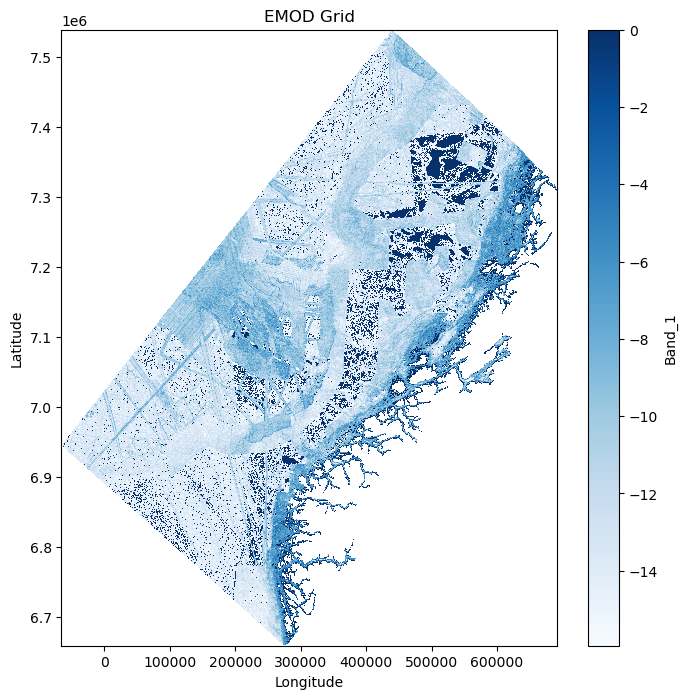

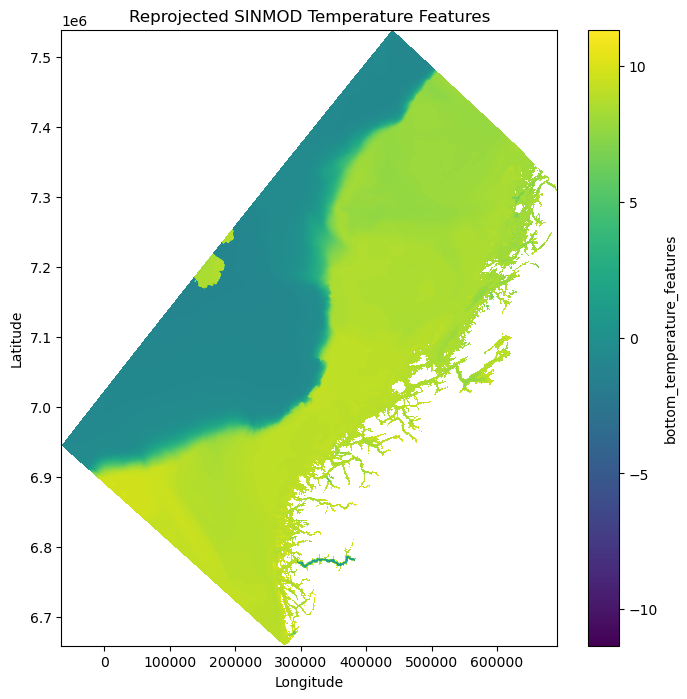

In [98]:
import xarray as xr
import rioxarray
import matplotlib.pyplot as plt
import rasterio

# Load the reprojected SINMOD dataset
# SINMOD_features_reprojected = xr.open_dataset('processed_data/features/SINMOD_features_reprojected.nc')

# Plotting the EMOD grid
fig, ax = plt.subplots(figsize=(8, 8))
tif.plot(ax=ax, cmap='Blues')
ax.set_title('EMOD Grid')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# Plotting the reprojected SINMOD data (bottom_temperature, for example)
fig, ax = plt.subplots(figsize=(8, 8))
SINMOD_features_reprojected['bottom_temperature_features'].isel(stat=0).plot(ax=ax, cmap='viridis')
ax.set_title('Reprojected SINMOD Temperature Features')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [ ]:
import xarray as xr
import rioxarray
import matplotlib.pyplot as plt
import rasterio

aspect = rioxarray.open_rasterio('raw_data/EMOD-tifs/aspect_cos.tif')
bathymetry = rioxarray.open_rasterio('raw_data/EMOD-tifs/bathymetry_32N_Clip_sample.tif')

# Plotting the EMOD grid
fig, ax = plt.subplots(figsize=(8, 8))
aspect.plot(ax=ax, cmap='Blues')
ax.set_title('EMOD Grid')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# Plotting the reprojected SINMOD data (bottom_temperature, for example)
fig, ax = plt.subplots(figsize=(8, 8))
bathymetry.plot(ax=ax, cmap='viridis')
ax.set_title('Reprojected SINMOD Temperature Features')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()